# Safety Benchmark Scaling Analysis - Comprehensive Visualizations

This notebook creates clear visualizations to analyze:
1. **Baseline Scaling**: Which benchmarks improve with model scale?
2. **Technique Effectiveness**: Which safety techniques work best?
3. **Scaling Behavior**: Do techniques become more/less effective at larger scales?

**Following SafetyWashing methodology**: Individual data points, Spearman correlations, slope-based categorization

## Setup and Imports

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import hashlib
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

print('✓ All imports successful')

✓ All imports successful


## Load Merged Data

**Note**: Run `preprocess_and_merge.ipynb` first to create `merged_data.csv`

In [228]:
# Load merged dataset
df = pd.read_csv('../data/merged_data.csv')

print(f'Loaded {len(df)} data points')
print(f'\nColumns: {list(df.columns)}')
print(f'\nFirst few rows:')
df.head()

Loaded 215 data points

Columns: ['Source paper', 'Technique', 'Model', 'Scale', 'Benchmark', 'Performance', 'scale_numeric']

First few rows:


,Source paper,Technique,Model,Scale,Benchmark,Performance,scale_numeric
0,https://arxiv.org/pdf/2503.17365v1,Baseline,DeepSeek-R1 Distill Llama 8B,8B,HARMBENCH ASR,46.7,8.0
1,https://arxiv.org/pdf/2503.17365v1,ICL,DeepSeek-R1 Distill Llama 8B,8B,HARMBENCH ASR,8.9,8.0
2,https://arxiv.org/pdf/2503.17365v1,Baseline,Gemma-2 9B-it,9B,HARMBENCH ASR,58.9,9.0
3,https://arxiv.org/pdf/2503.17365v1,ICL,Gemma-2 9B-it,9B,HARMBENCH ASR,26.7,9.0
4,https://arxiv.org/pdf/2311.10702,Baseline,Llama 2-13B,13B,TOXIGEN,85.7,13.0


## Data Preprocessing: Critical Corrections

**Two critical preprocessing steps:**

1. **Unique Technique Identifiers**: Same technique name from different papers = different implementations
2. **Benchmark Directionality**: Some benchmarks (WMDP: BIO, CHEM, CYBER) have inverted scoring (higher = worse safety)

In [229]:
df.Benchmark.unique()

array(['HARMBENCH ASR', 'TOXIGEN', 'TRUTHFULQA', 'BIO', 'CHEM', 'CYBER',
       'HARMBENCH', 'WILDJAILBREAK', 'DOANYTHINGNOW', 'XSTEST',
       'JAILBREAKTRIGGER', 'WILDGUARDTEST'], dtype=object)

In [230]:
# STEP 1: Create unique technique identifiers (Technique + Source Paper)
def create_paper_id(source_paper):
    """Create a short hash ID from the source paper URL"""
    if pd.isna(source_paper):
        return 'unknown'
    return hashlib.md5(str(source_paper).encode()).hexdigest()[:8]

df['paper_id'] = df['Source paper'].apply(create_paper_id)
df['technique_id'] = df['Technique'] + '_' + df['paper_id']

print(f"✓ Created unique technique identifiers")
print(f"  Original technique names: {df['Technique'].nunique()}")
print(f"  Unique technique_id count: {df['technique_id'].nunique()}")

# STEP 2: Identify and handle benchmark directionality
# WMDP benchmarks (BIO, CHEM, CYBER): higher score = worse safety (need inversion)
# Other benchmarks: higher score = better safety (already correct)

INVERTED_BENCHMARKS = ['BIO', 'WMDP', 'CHEM', 'CYBER', 'TOXIGEN', 'HARMBENCH ASR', 'WILDJAILBREAK', 'JAILBREAKTRIGGER', 'WILDGUARDTEST']

print(f"\n✓ Benchmark directionality identified:")
print(f"  Inverted (higher = worse): {INVERTED_BENCHMARKS}")

# STEP 3: Invert performance for WMDP benchmarks to make higher = better consistently
df['Performance_normalized'] = df['Performance'].copy()

for benchmark in INVERTED_BENCHMARKS:
    mask = df['Benchmark'] == benchmark
    if mask.sum() > 0:
        # Invert: new_score = 1 - old_score (assuming scores are 0-1)
        # If scores are percentages (0-100), use: 100 - old_score
        max_val = df.loc[mask, 'Performance'].max()
        if max_val > 1.5:  # Likely percentage scale
            df.loc[mask, 'Performance_normalized'] = 100 - df.loc[mask, 'Performance']
        else:  # Likely 0-1 scale
            df.loc[mask, 'Performance_normalized'] = 1 - df.loc[mask, 'Performance']
        
        print(f"  Inverted {benchmark}: {mask.sum()} data points")

print(f"\n✓ All benchmarks now normalized: higher = better safety")
print(f"\nExample - BIO benchmark before/after:")
bio_sample = df[df['Benchmark'] == 'BIO'][['Technique', 'Model', 'Performance', 'Performance_normalized']].head(5)
print(bio_sample)

✓ Created unique technique identifiers
  Original technique names: 15
  Unique technique_id count: 26

✓ Benchmark directionality identified:
  Inverted (higher = worse): ['BIO', 'WMDP', 'CHEM', 'CYBER', 'TOXIGEN', 'HARMBENCH ASR', 'WILDJAILBREAK', 'JAILBREAKTRIGGER', 'WILDGUARDTEST']
  Inverted BIO: 12 data points
  Inverted CHEM: 12 data points
  Inverted CYBER: 12 data points
  Inverted TOXIGEN: 19 data points
  Inverted HARMBENCH ASR: 8 data points
  Inverted WILDJAILBREAK: 14 data points
  Inverted JAILBREAKTRIGGER: 8 data points
  Inverted WILDGUARDTEST: 8 data points

✓ All benchmarks now normalized: higher = better safety

Example - BIO benchmark before/after:
    Technique   Model  Performance  Performance_normalized
74   Baseline   OLMO2     0.741176                0.258824
75        DPO   OLMO2     0.588235                0.411765
76        SFT   OLMO2     0.631373                0.368627
100  Baseline  TULU 2     0.850980                0.149020
101       DPO  TULU 2     0.

---
# Phase 1: Data Overview
---

## 1.1 Dataset Statistics Dashboard

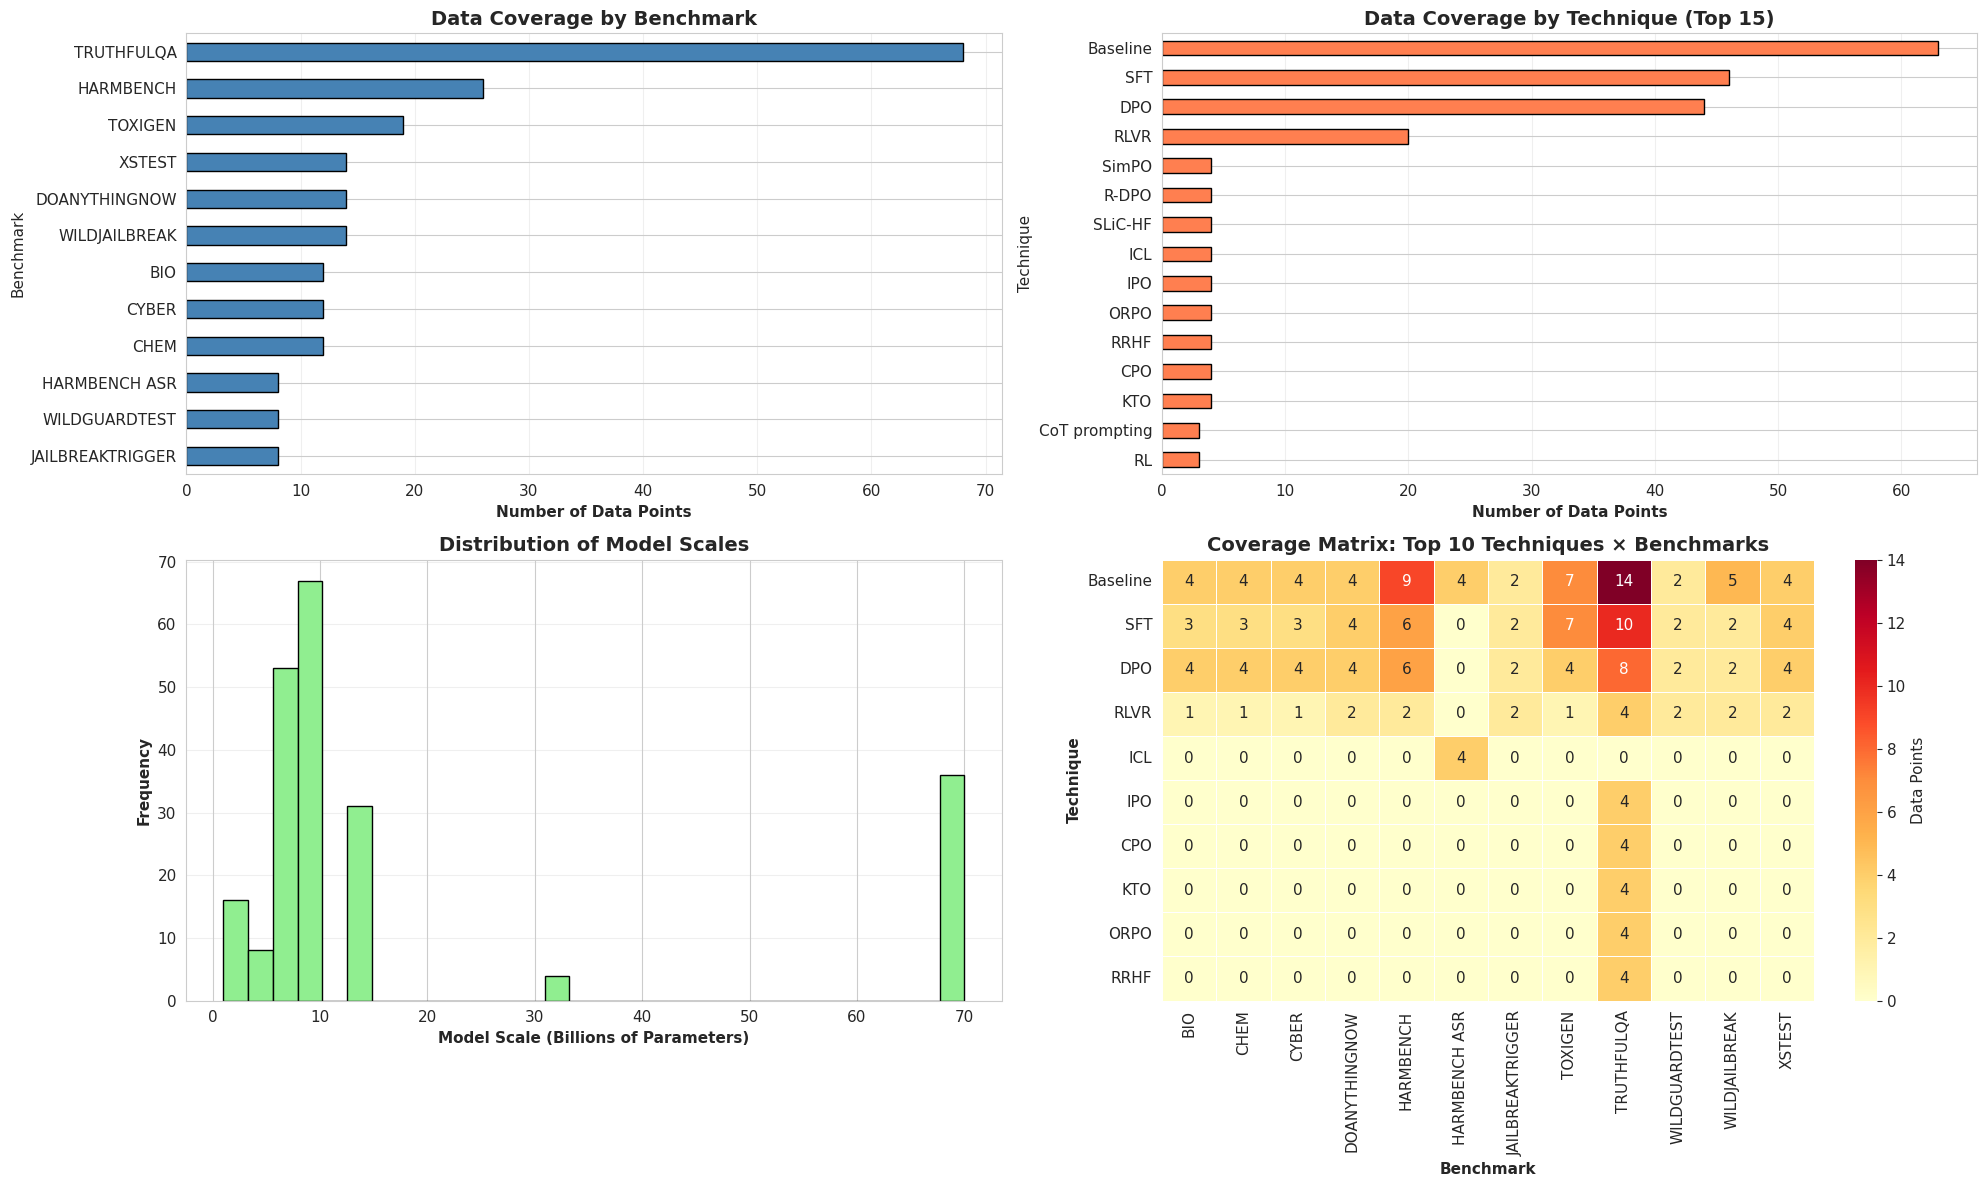


📊 Dataset Summary:
  Total data points: 215
  Unique benchmarks: 12
  Unique techniques (by name): 15
  Unique techniques (by ID): 26
  Unique models: 18
  Scale range: 1B - 70B


In [231]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Data points per benchmark
ax1 = axes[0, 0]
benchmark_counts = df['Benchmark'].value_counts().sort_values(ascending=True)
benchmark_counts.plot(kind='barh', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Data Points', fontweight='bold')
ax1.set_title('Data Coverage by Benchmark', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Data points per technique (top 15)
ax2 = axes[0, 1]
technique_counts = df['Technique'].value_counts().head(15).sort_values(ascending=True)
technique_counts.plot(kind='barh', ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Number of Data Points', fontweight='bold')
ax2.set_title('Data Coverage by Technique (Top 15)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Distribution of model scales
ax3 = axes[1, 0]
df['scale_numeric'].hist(bins=30, ax=ax3, color='lightgreen', edgecolor='black')
ax3.set_xlabel('Model Scale (Billions of Parameters)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Distribution of Model Scales', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Coverage matrix
ax4 = axes[1, 1]
coverage_matrix = df.groupby(['Technique', 'Benchmark']).size().unstack(fill_value=0)
top_techniques = df['Technique'].value_counts().head(10).index
coverage_subset = coverage_matrix.loc[top_techniques]
sns.heatmap(coverage_subset, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Data Points'}, ax=ax4)
ax4.set_title('Coverage Matrix: Top 10 Techniques × Benchmarks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Benchmark', fontweight='bold')
ax4.set_ylabel('Technique', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'\n📊 Dataset Summary:')
print(f'  Total data points: {len(df)}')
print(f'  Unique benchmarks: {df["Benchmark"].nunique()}')
print(f'  Unique techniques (by name): {df["Technique"].nunique()}')
print(f'  Unique techniques (by ID): {df["technique_id"].nunique()}')
print(f'  Unique models: {df["Model"].nunique()}')
print(f'  Scale range: {df["scale_numeric"].min():.0f}B - {df["scale_numeric"].max():.0f}B')

Matrix shape: (99, 12)  (rows = Model × Scale × Technique, cols = Benchmarks)

Sample (top 40 rows):
Benchmark                                     BIO  CHEM  CYBER  DOANYTHINGNOW  HARMBENCH  HARMBENCH ASR  JAILBREAKTRIGGER  TOXIGEN  TRUTHFULQA  WILDGUARDTEST  WILDJAILBREAK  XSTEST
Model                        Scale Technique                                                                                                                                        
DeepSeek-R1 Distill Llama 8B 8B    Baseline     0     0      0              0          0              1                 0        0           0              0              0       0
                                   ICL          0     0      0              0          0              1                 0        0           0              0              0       0
Gemma-2 9B-it                9B    Baseline     0     0      0              0          0              1                 0        0           0              0              0   

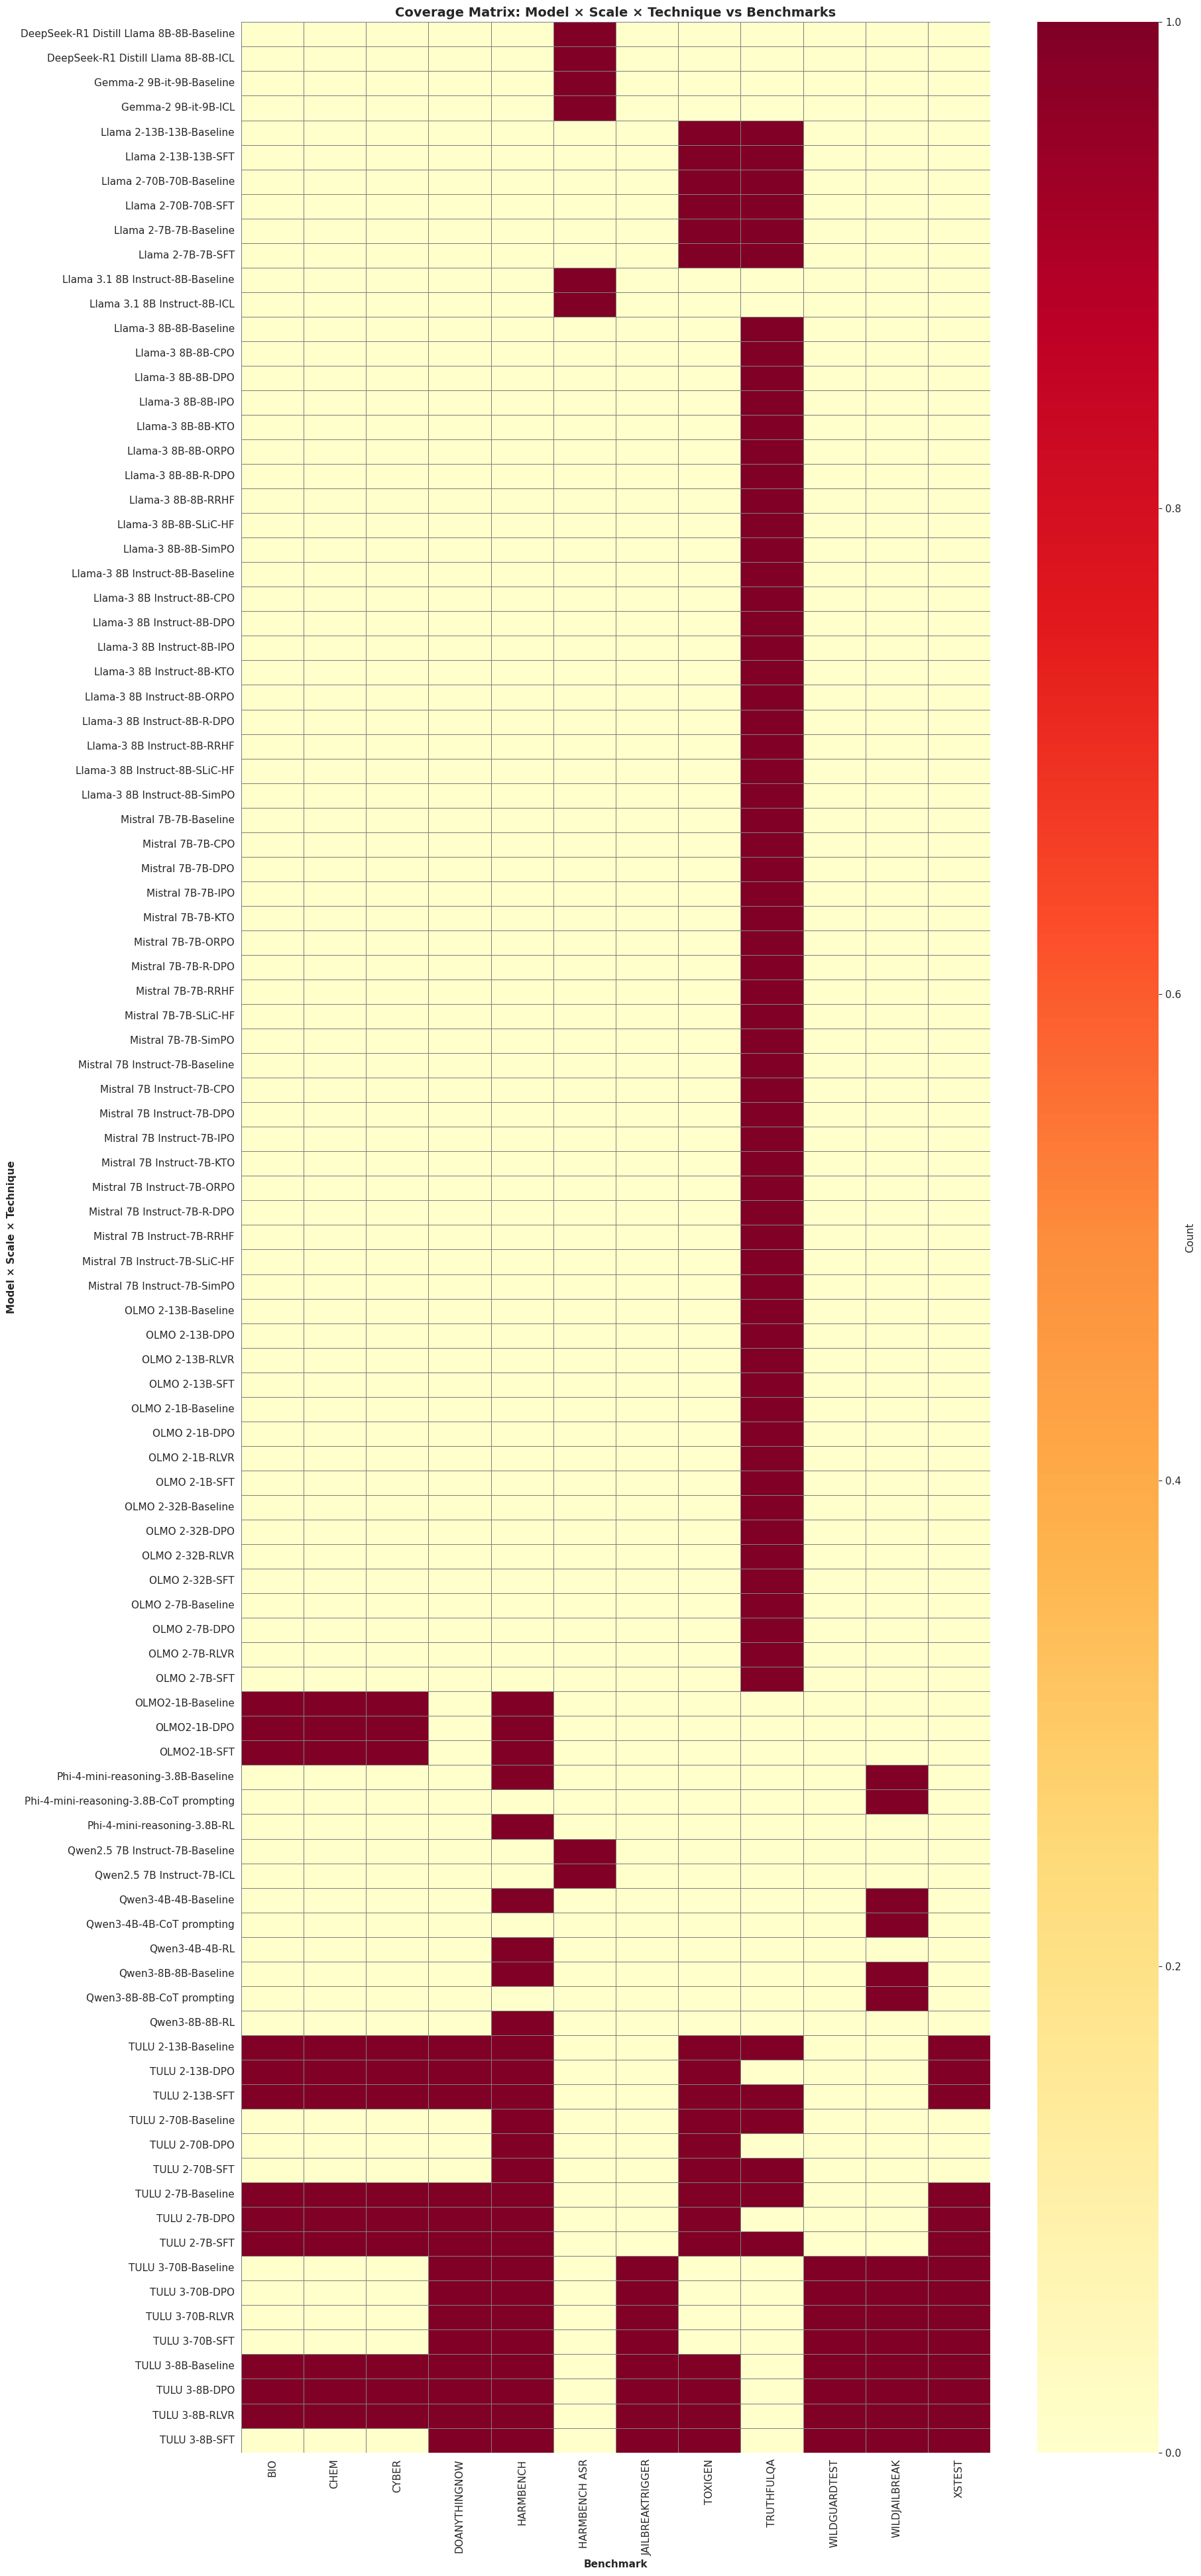

Benchmark                                     BIO  CHEM  CYBER  DOANYTHINGNOW  \
Model                        Scale Technique                                    
DeepSeek-R1 Distill Llama 8B 8B    Baseline     0     0      0              0   
                                   ICL          0     0      0              0   
Gemma-2 9B-it                9B    Baseline     0     0      0              0   
                                   ICL          0     0      0              0   
Llama 2-13B                  13B   Baseline     0     0      0              0   
...                                           ...   ...    ...            ...   
TULU 3                       70B   SFT          0     0      0              1   
                             8B    Baseline     1     1      1              1   
                                   DPO          1     1      1              1   
                                   RLVR         1     1      1              1   
                                   SFT          0     0      0              1   

Benchmark                                     HARMBENCH  HARMBENCH ASR  \
Model                        Scale Technique                             
DeepSeek-R1 Distill Llama 8B 8B    Baseline           0              1   
                                   ICL                0              1   
Gemma-2 9B-it                9B    Baseline           0              1   
                                   ICL                0              1   
Llama 2-13B                  13B   Baseline           0              0   
...                                                 ...            ...   
TULU 3                       70B   SFT                1              0   
                             8B    Baseline           1              0   
                                   DPO                1              0   
                                   RLVR               1              0   
                                   SFT                1              0   

Benchmark                                     JAILBREAKTRIGGER  TOXIGEN  \
Model                        Scale Technique                              
DeepSeek-R1 Distill Llama 8B 8B    Baseline                  0        0   
                                   ICL                       0        0   
Gemma-2 9B-it                9B    Baseline                  0        0   
                                   ICL                       0        0   
Llama 2-13B                  13B   Baseline                  0        1   
...                                                        ...      ...   
TULU 3                       70B   SFT                       1        0   
                             8B    Baseline                  1        1   
                                   DPO                       1        1   
                                   RLVR                      1        1   
                                   SFT                       1        1   

Benchmark                                     TRUTHFULQA  WILDGUARDTEST  \
Model                        Scale Technique                              
DeepSeek-R1 Distill Llama 8B 8B    Baseline            0              0   
                                   ICL                 0              0   
Gemma-2 9B-it                9B    Baseline            0              0   
                                   ICL                 0              0   
Llama 2-13B                  13B   Baseline            1              0   
...                                                  ...            ...   
TULU 3                       70B   SFT                 0              1   
                             8B    Baseline            0              1   
                                   DPO                 0              1   
                                   RLVR                0              1   
                                   SFT                 0              1   

Benchmark                      

In [232]:
# Matrix: count of entries for (Model, Scale, Technique) vs Benchmark
model_scale_tech_vs_bench = pd.crosstab(
  index=[df['Model'], df['Scale'], df['Technique']],
  columns=df['Benchmark']
).fillna(0).astype(int)

print(f"Matrix shape: {model_scale_tech_vs_bench.shape}  (rows = Model × Scale × Technique, cols = Benchmarks)\n")
print("Sample (top 40 rows):")
print(model_scale_tech_vs_bench.head(40).to_string())

# Return the full matrix as the cell output for easy inspection in the notebook
# Plot heatmap of the (Model, Scale, Technique) vs Benchmark matrix
annot = (model_scale_tech_vs_bench.shape[0] <= 30) and (model_scale_tech_vs_bench.shape[1] <= 20)
fig_height = max(6, int(model_scale_tech_vs_bench.shape[0] * 0.4))

fig, ax = plt.subplots(figsize=(18, fig_height))
sns.heatmap(model_scale_tech_vs_bench, cmap='YlOrRd', linewidths=0.4, linecolor='gray',
      cbar_kws={'label': 'Count'}, annot=annot, fmt='d' if annot else None, ax=ax)

ax.set_title('Coverage Matrix: Model × Scale × Technique vs Benchmarks', fontsize=14, fontweight='bold')
ax.set_xlabel('Benchmark', fontweight='bold')
ax.set_ylabel('Model × Scale × Technique', fontweight='bold')
plt.tight_layout()
plt.show()

# Also return the DataFrame for inspection
model_scale_tech_vs_bench

---
# Phase 2: Baseline Scaling Analysis
---

## 2.1 Baseline Performance vs Scale

**Goal**: Identify which benchmarks are "saturated" (improve with scale) vs "not saturated"

In [233]:
# Update Benchmark name to HARMBENCH for HARMBENCH ASR rows
df.loc[df['Benchmark'] == 'HARMBENCH ASR', 'Benchmark'] = 'HARMBENCH'
# Remove benchmarks from df
df = df[~df['Benchmark'].isin(['WILDGUARDTEST', 'WILDJAILBREAK', 'JAILBREAKTRIGGER'])]

df = df[df['Technique'].isin(['Baseline', 'SFT', 'DPO', 'RLVR'])]

print(f"✓ Merged HARMBENCH variants into single HARMBENCH category")
print(f"  Before merging: {len(diff_df)} rows")
print(f"  After merging: {len(diff_df.drop_duplicates(['Model', 'Scale', 'Benchmark', 'Technique', 'technique_id']))} rows")

✓ Merged HARMBENCH variants into single HARMBENCH category
  Before merging: 84 rows
  After merging: 84 rows


In [234]:
# Extract baseline data - using normalized performance
baseline_df = df[df['Technique'] == 'Baseline'].copy()

print(f'Baseline data points: {len(baseline_df)}')
print(f'Benchmarks with baseline data: {sorted(baseline_df["Benchmark"].unique())}')

Baseline data points: 54
Benchmarks with baseline data: ['BIO', 'CHEM', 'CYBER', 'DOANYTHINGNOW', 'HARMBENCH', 'TOXIGEN', 'TRUTHFULQA', 'XSTEST']


In [235]:
# Calculate correlation and slope for each benchmark using normalized performance
benchmark_stats = []

for benchmark in baseline_df['Benchmark'].unique():
    bench_data = baseline_df[baseline_df['Benchmark'] == benchmark]
    
    if len(bench_data) >= 2:
        scales = bench_data['scale_numeric'].values
        perfs = bench_data['Performance_normalized'].values  # UPDATED: use normalized
        
        # Spearman correlation
        corr, p_value = spearmanr(scales, perfs)
        
        # Linear regression for slope
        model = LinearRegression()
        model.fit(scales.reshape(-1, 1), perfs)
        slope = model.coef_[0]
        r2 = model.score(scales.reshape(-1, 1), perfs)
        
        benchmark_stats.append({
            'Benchmark': benchmark,
            'Correlation': corr,
            'P_value': p_value,
            'Slope': slope,
            'R2': r2,
            'N_points': len(bench_data),
            'Category': 'Saturated' if corr > 0.5 else 'Not Saturated'
        })

bench_stats_df = pd.DataFrame(benchmark_stats)

print('\n📈 Benchmark Scaling Statistics (with normalized scores):')
print('='*80)
print(bench_stats_df.to_string(index=False))


📈 Benchmark Scaling Statistics (with normalized scores):
    Benchmark  Correlation  P_value     Slope       R2  N_points      Category
    HARMBENCH     0.659310 0.014232  0.556928 0.276425        13     Saturated
      TOXIGEN    -0.584906 0.167775 -0.141952 0.167080         7 Not Saturated
   TRUTHFULQA     0.004542 0.987706 -0.033619 0.003675        14 Not Saturated
          BIO    -0.400000 0.600000 -0.004865 0.255179         4 Not Saturated
         CHEM    -0.400000 0.600000 -0.004736 0.169420         4 Not Saturated
        CYBER    -0.400000 0.600000 -0.006734 0.203524         4 Not Saturated
DOANYTHINGNOW     1.000000 0.000000  0.543869 0.949065         4     Saturated
       XSTEST     0.400000 0.600000  0.350414 0.199079         4 Not Saturated


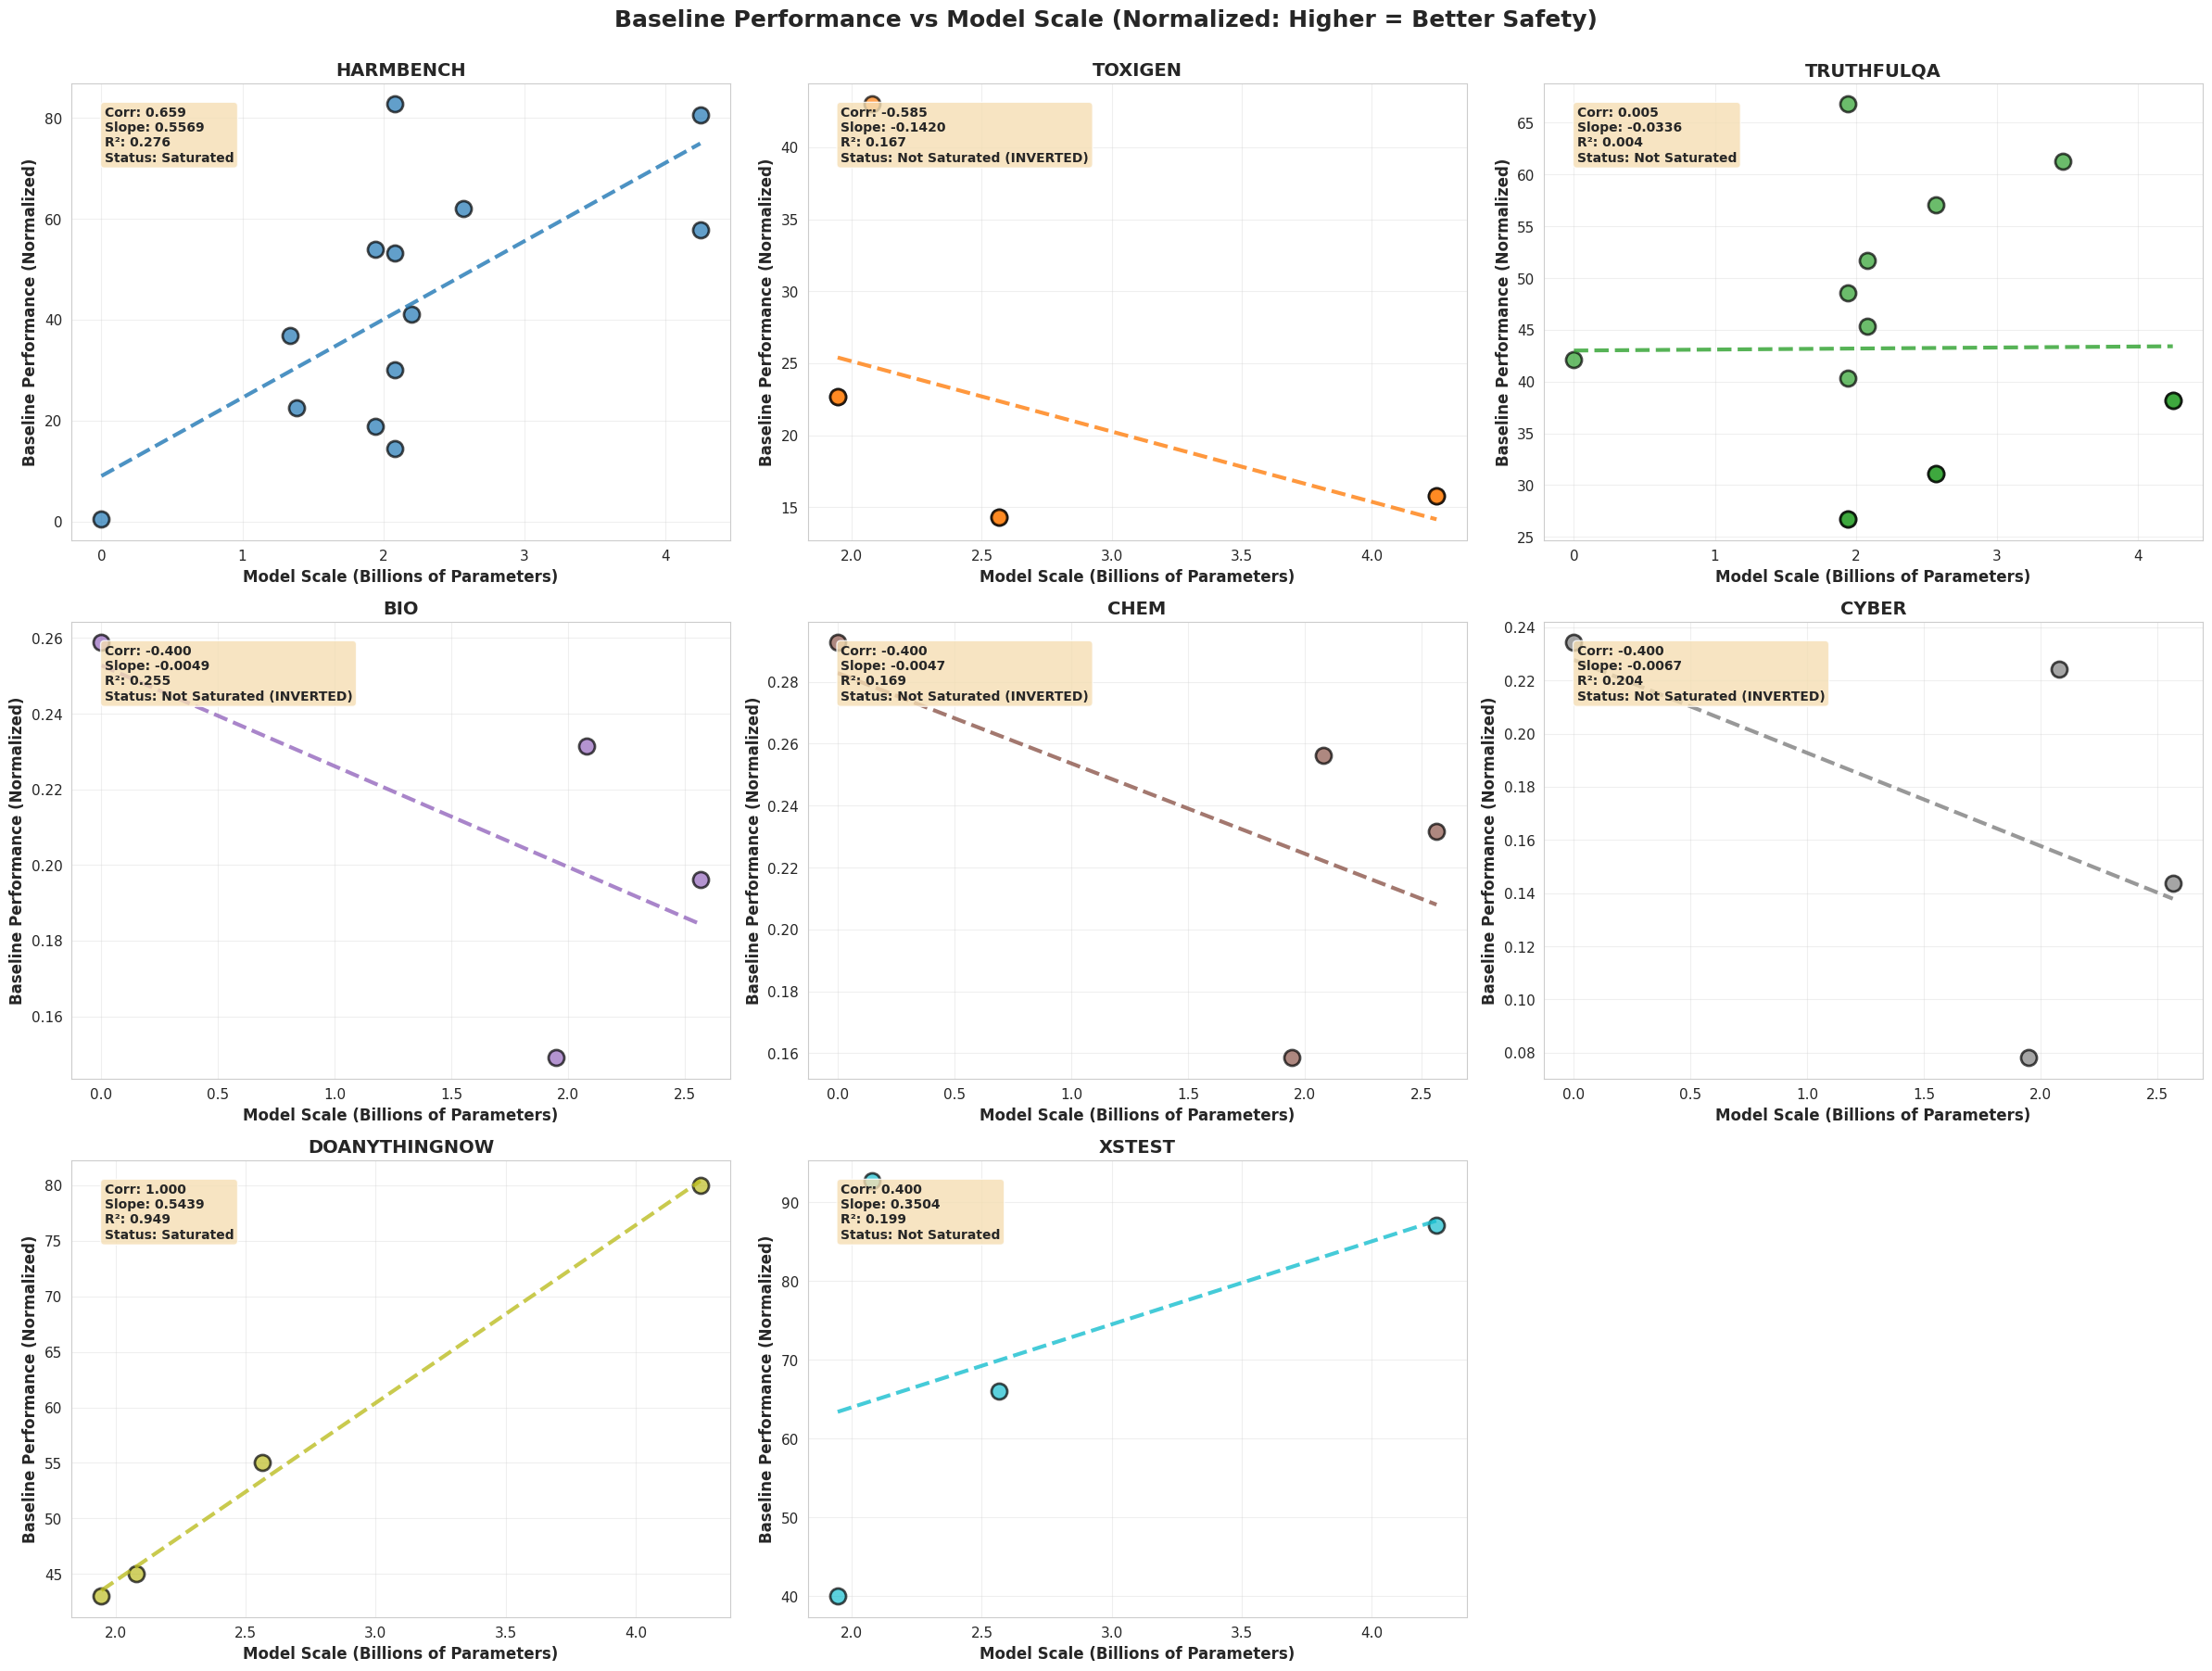

In [236]:
# Visualize baseline scaling with normalized performance
benchmarks = baseline_df['Benchmark'].unique()
n_benchmarks = len(benchmarks)
n_cols = min(3, n_benchmarks)
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
if n_benchmarks == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_benchmarks > 1 else [axes]

colors = plt.cm.tab10(np.linspace(0, 1, n_benchmarks))

for idx, benchmark in enumerate(benchmarks):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    bench_data = baseline_df[baseline_df['Benchmark'] == benchmark]
    
    # Scatter plot - using normalized performance
    ax.scatter(np.log(bench_data['scale_numeric']), bench_data['Performance_normalized'],
              s=150, alpha=0.7, color=colors[idx], edgecolors='black', linewidth=2)
    
    # Trend line
    if len(bench_data) >= 2:
        scales = np.log(bench_data['scale_numeric'].values.reshape(-1, 1))
        perfs = bench_data['Performance_normalized'].values
        model = LinearRegression()
        model.fit(scales, perfs)
        
        scale_range = np.linspace(scales.min(), scales.max(), 100)
        pred = model.predict(scale_range.reshape(-1, 1))
        ax.plot(scale_range, pred, '--', color=colors[idx], linewidth=3, alpha=0.8)
        
        # Add statistics
        stats = bench_stats_df[bench_stats_df['Benchmark'] == benchmark].iloc[0]
        
        # Mark if benchmark is inverted
        inverted_marker = ' (INVERTED)' if benchmark in INVERTED_BENCHMARKS else ''
        
        stats_text = (
            f"Corr: {stats['Correlation']:.3f}\n"
            f"Slope: {stats['Slope']:.4f}\n"
            f"R²: {stats['R2']:.3f}\n"
            f"Status: {stats['Category']}{inverted_marker}"
        )
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Model Scale (Billions of Parameters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Baseline Performance (Normalized)', fontsize=12, fontweight='bold')
    ax.set_title(f'{benchmark}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Remove extra subplots
for idx in range(n_benchmarks, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Baseline Performance vs Model Scale (Normalized: Higher = Better Safety)', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 2.2 Benchmark Saturation Categorization

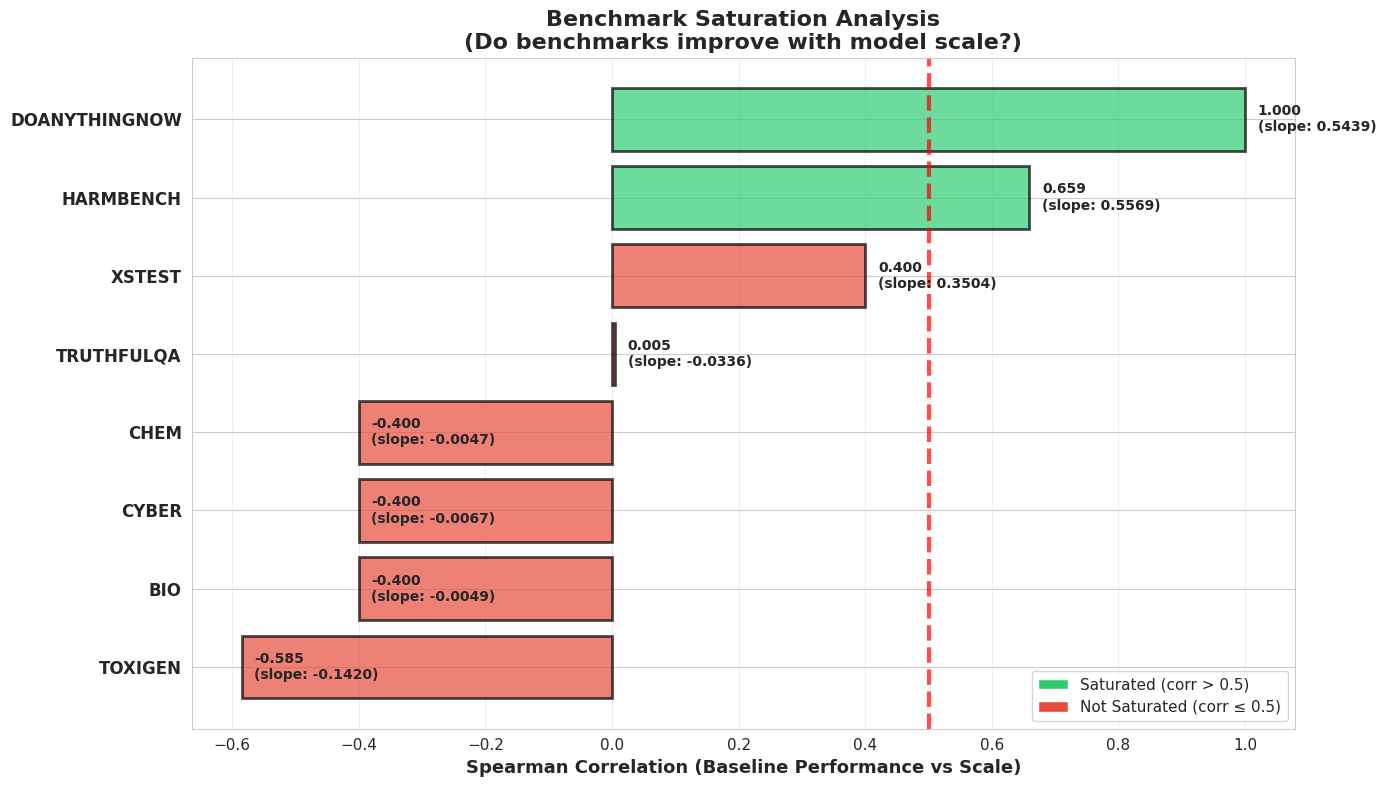


📊 Benchmark Categories:
Saturated: ['HARMBENCH', 'DOANYTHINGNOW']
Not Saturated: ['TOXIGEN', 'TRUTHFULQA', 'BIO', 'CHEM', 'CYBER', 'XSTEST']


In [237]:
# Horizontal bar chart with categorization
fig, ax = plt.subplots(figsize=(14, 8))

bench_stats_sorted = bench_stats_df.sort_values('Correlation')
colors = ['#2ECC71' if cat == 'Saturated' else '#E74C3C' 
          for cat in bench_stats_sorted['Category']]

y_pos = np.arange(len(bench_stats_sorted))
bars = ax.barh(y_pos, bench_stats_sorted['Correlation'], 
               color=colors, edgecolor='black', linewidth=2, alpha=0.7)

# Add threshold line
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=3, 
          alpha=0.7, label='Saturation threshold (0.5)')

# Add value labels
for i, (bar, row) in enumerate(zip(bars, bench_stats_sorted.itertuples())):
    width = bar.get_width()
    label_text = f"{row.Correlation:.3f}\n(slope: {row.Slope:.4f})"
    ax.text(width + 0.02, bar.get_y() + bar.get_height()/2.,
           label_text, ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(bench_stats_sorted['Benchmark'], fontsize=12, fontweight='bold')
ax.set_xlabel('Spearman Correlation (Baseline Performance vs Scale)', 
             fontsize=13, fontweight='bold')
ax.set_title('Benchmark Saturation Analysis\n(Do benchmarks improve with model scale?)',
            fontsize=16, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ECC71', label='Saturated (corr > 0.5)'),
    Patch(facecolor='#E74C3C', label='Not Saturated (corr ≤ 0.5)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n📊 Benchmark Categories:')
print('='*60)
for category in ['Saturated', 'Not Saturated']:
    benchmarks = bench_stats_df[bench_stats_df['Category'] == category]['Benchmark'].tolist()
    print(f'{category}: {benchmarks}')

---
# Phase 3: Technique Performance Analysis
---

## 3.1 Calculate Performance Difference from Baseline

In [238]:
# Calculate difference from baseline for each data point
# UPDATED: Use technique_id (unique per paper) and Performance_normalized
diff_data = []

for model in df['Model'].unique():
    for scale in df[df['Model'] == model]['Scale'].unique():
        for benchmark in df['Benchmark'].unique():
            subset = df[
                (df['Model'] == model) &
                (df['Scale'] == scale) &
                (df['Benchmark'] == benchmark)
            ]
            
            # Get baseline performance (normalized)
            baseline_perf = subset[subset['Technique'] == 'Baseline']['Performance_normalized']
            if len(baseline_perf) == 0:
                continue
            
            baseline_val = baseline_perf.values[0]
            scale_numeric = subset['scale_numeric'].values[0]
            
            # Calculate difference for each UNIQUE technique (technique_id)
            for technique_id in subset['technique_id'].unique():
                tech_row = subset[subset['technique_id'] == technique_id].iloc[0]
                technique_name = tech_row['Technique']
                paper_id = tech_row['paper_id']
                
                if technique_name == 'Baseline':
                    continue
                
                tech_val = tech_row['Performance_normalized']
                diff = tech_val - baseline_val if benchmark not in INVERTED_BENCHMARKS else baseline_val - tech_val
                
                diff_data.append({
                    'Model': model,
                    'Scale': scale,
                    'scale_numeric': scale_numeric,
                    'Benchmark': benchmark,
                    'Technique': technique_name,
                    'technique_id': technique_name,
                    'paper_id': paper_id,
                    'Source_paper': tech_row['Source paper'],
                    'Baseline_perf': baseline_val,
                    'Technique_perf': tech_val,
                    'Diff_from_baseline': diff,
                    'Relative_change_pct': (diff / baseline_val) * 100 if baseline_val != 0 else 0
                })

diff_df = pd.DataFrame(diff_data)

print(f'\n✓ Calculated performance differences for {len(diff_df)} data points')
print(f'\nUnique techniques (by NAME): {diff_df["Technique"].nunique()}')
print(f'Unique techniques (by ID): {diff_df["technique_id"].nunique()}')
print(f'\n💡 Same technique from different papers is now treated as different!')
print(f'\nSample data:')
print(diff_df[['Technique', 'paper_id', 'technique_id', 'Benchmark', 'Diff_from_baseline']].head(10))


✓ Calculated performance differences for 92 data points

Unique techniques (by NAME): 3
Unique techniques (by ID): 3

💡 Same technique from different papers is now treated as different!

Sample data:
  Technique  paper_id technique_id   Benchmark  Diff_from_baseline
0       SFT  d9032089          SFT     TOXIGEN              -67.00
1       SFT  d9032089          SFT  TRUTHFULQA               14.20
2       SFT  d9032089          SFT     TOXIGEN              -84.20
3       SFT  d9032089          SFT  TRUTHFULQA               19.70
4       SFT  d9032089          SFT     TOXIGEN              -37.40
5       SFT  d9032089          SFT  TRUTHFULQA               14.10
6       DPO  a8af512c          DPO  TRUTHFULQA                8.15
7       DPO  a8af512c          DPO  TRUTHFULQA                7.35
8       DPO  a8af512c          DPO  TRUTHFULQA               12.71
9       DPO  a8af512c          DPO  TRUTHFULQA               -0.10


## 3.2 Performance Gain Heatmap

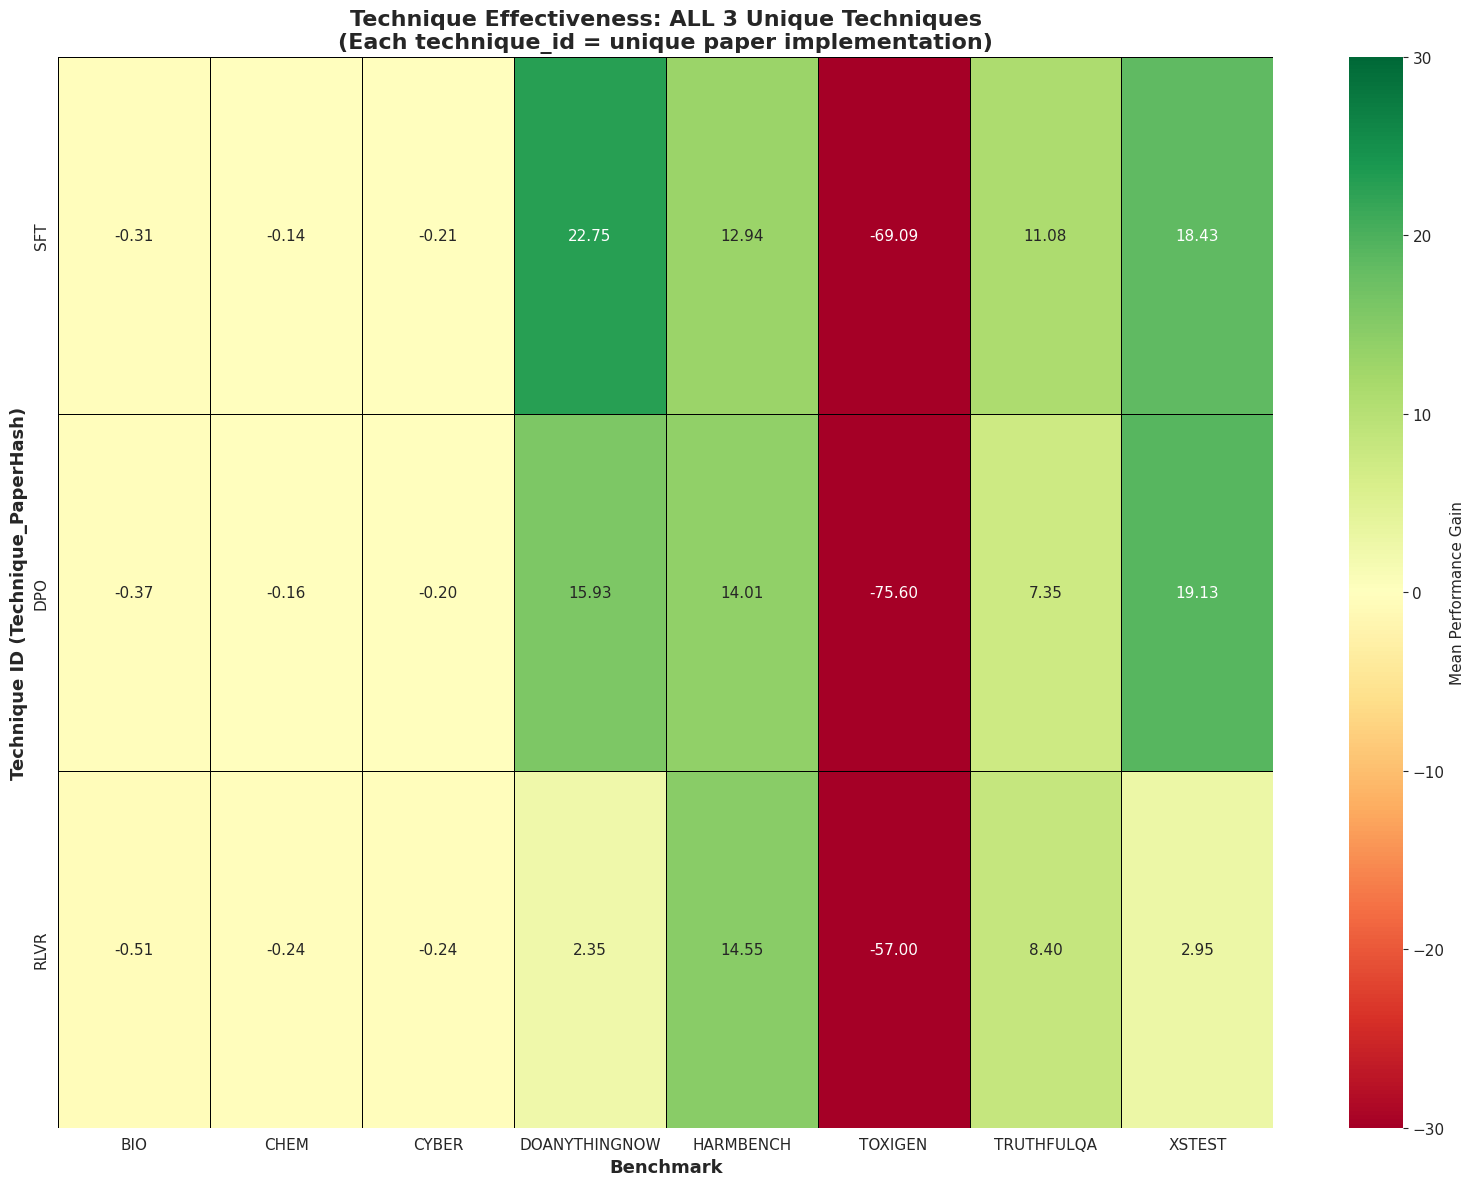


🎯 Showing ALL 3 unique technique implementations
  Green = Technique improves over baseline
  Red = Technique worse than baseline
  Yellow = Similar to baseline


In [239]:
# Create heatmap showing ALL unique techniques (by technique_id)
# Group by technique_id to show all unique implementations
heatmap_data = diff_df.pivot_table(
    index='technique_id',
    columns='Benchmark',
    values='Diff_from_baseline',
    aggfunc='mean'
)

# Sort by mean gain across all benchmarks
heatmap_data['mean_gain'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('mean_gain', ascending=False)
heatmap_data = heatmap_data.drop('mean_gain', axis=1)

# Create figure with appropriate height for all techniques
n_techniques = len(heatmap_data)
fig_height = max(12, n_techniques * 0.4)  # At least 12, or 0.4 per technique

fig, ax = plt.subplots(figsize=(16, fig_height))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
           linewidths=0.5, linecolor='black', cbar_kws={'label': 'Mean Performance Gain'},
           ax=ax, vmin=-30, vmax=30)

ax.set_title(f'Technique Effectiveness: ALL {n_techniques} Unique Techniques\n(Each technique_id = unique paper implementation)',
            fontsize=16, fontweight='bold')
ax.set_xlabel('Benchmark', fontsize=13, fontweight='bold')
ax.set_ylabel('Technique ID (Technique_PaperHash)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'\n🎯 Showing ALL {n_techniques} unique technique implementations')
print(f'  Green = Technique improves over baseline')
print(f'  Red = Technique worse than baseline')
print(f'  Yellow = Similar to baseline')

---
# Phase 4: Scaling Behavior Analysis
---

## 4.1 Performance Gain vs Scale (Critical Analysis)

**Key Question**: Do techniques become MORE or LESS effective at larger scales?

In [240]:
# Calculate scaling behavior for each technique-benchmark combination
# UPDATED: Use technique_id for unique identification
technique_scaling = []

for technique_id in diff_df['technique_id'].unique():
    technique_name = diff_df[diff_df['technique_id'] == technique_id]['Technique'].iloc[0]
    
    for benchmark in diff_df['Benchmark'].unique():
        subset = diff_df[
            (diff_df['technique_id'] == technique_id) &
            (diff_df['Benchmark'] == benchmark)
        ]
        
        if len(subset) >= 2:
            scales = subset['scale_numeric'].values
            diffs = subset['Diff_from_baseline'].values
            
            # Spearman correlation
            corr, p_value = spearmanr(scales, diffs)
            
            # Linear regression
            model = LinearRegression()
            model.fit(scales.reshape(-1, 1), diffs)
            slope = model.coef_[0]
            r2 = model.score(scales.reshape(-1, 1), diffs)
            
            # Categorize
            if corr > 0.3:
                category = 'Gain Increases with Scale'
            elif corr < -0.3:
                category = 'Gain Decreases with Scale'
            else:
                category = 'Gain Stable with Scale'
            
            technique_scaling.append({
                'Technique': technique_name,
                'technique_id': technique_id,
                'Benchmark': benchmark,
                'Correlation': corr,
                'P_value': p_value,
                'Slope': slope,
                'R2': r2,
                'N_points': len(subset),
                'Category': category,
                'Mean_gain': diffs.mean()
            })

tech_scaling_df = pd.DataFrame(technique_scaling)

print(f'\n✓ Analyzed scaling behavior for {len(tech_scaling_df)} technique-benchmark combinations')
print(f'  (Using unique technique_id to distinguish same techniques from different papers)')
print(f'\nTop 20 results:')
print(tech_scaling_df.sort_values('Slope', ascending=False).head(20)[[
    'Technique', 'Benchmark', 'Correlation', 'Slope', 'Mean_gain', 'Category'
]].to_string(index=False))


✓ Analyzed scaling behavior for 20 technique-benchmark combinations
  (Using unique technique_id to distinguish same techniques from different papers)

Top 20 results:
Technique     Benchmark  Correlation     Slope  Mean_gain                  Category
      DPO    TRUTHFULQA     0.343720  0.225402   7.351250 Gain Increases with Scale
      SFT    TRUTHFULQA     0.503236  0.195114  11.080000 Gain Increases with Scale
     RLVR    TRUTHFULQA     0.800000  0.168470   8.400000 Gain Increases with Scale
      SFT     HARMBENCH     0.811679  0.139136  12.944792 Gain Increases with Scale
      DPO     HARMBENCH     0.608760  0.130140  14.007292 Gain Increases with Scale
     RLVR     HARMBENCH     1.000000  0.085484  14.550000 Gain Increases with Scale
     RLVR        XSTEST     1.000000  0.075806   2.950000 Gain Increases with Scale
      DPO          CHEM    -0.400000 -0.014291  -0.155488 Gain Decreases with Scale
      DPO         CYBER    -0.400000 -0.017061  -0.199622 Gain Decreases wi

## 4.1.5 Scatter Plots: Gain vs Scale per Benchmark

**Visual analysis**: See how each technique's effectiveness changes with model scale

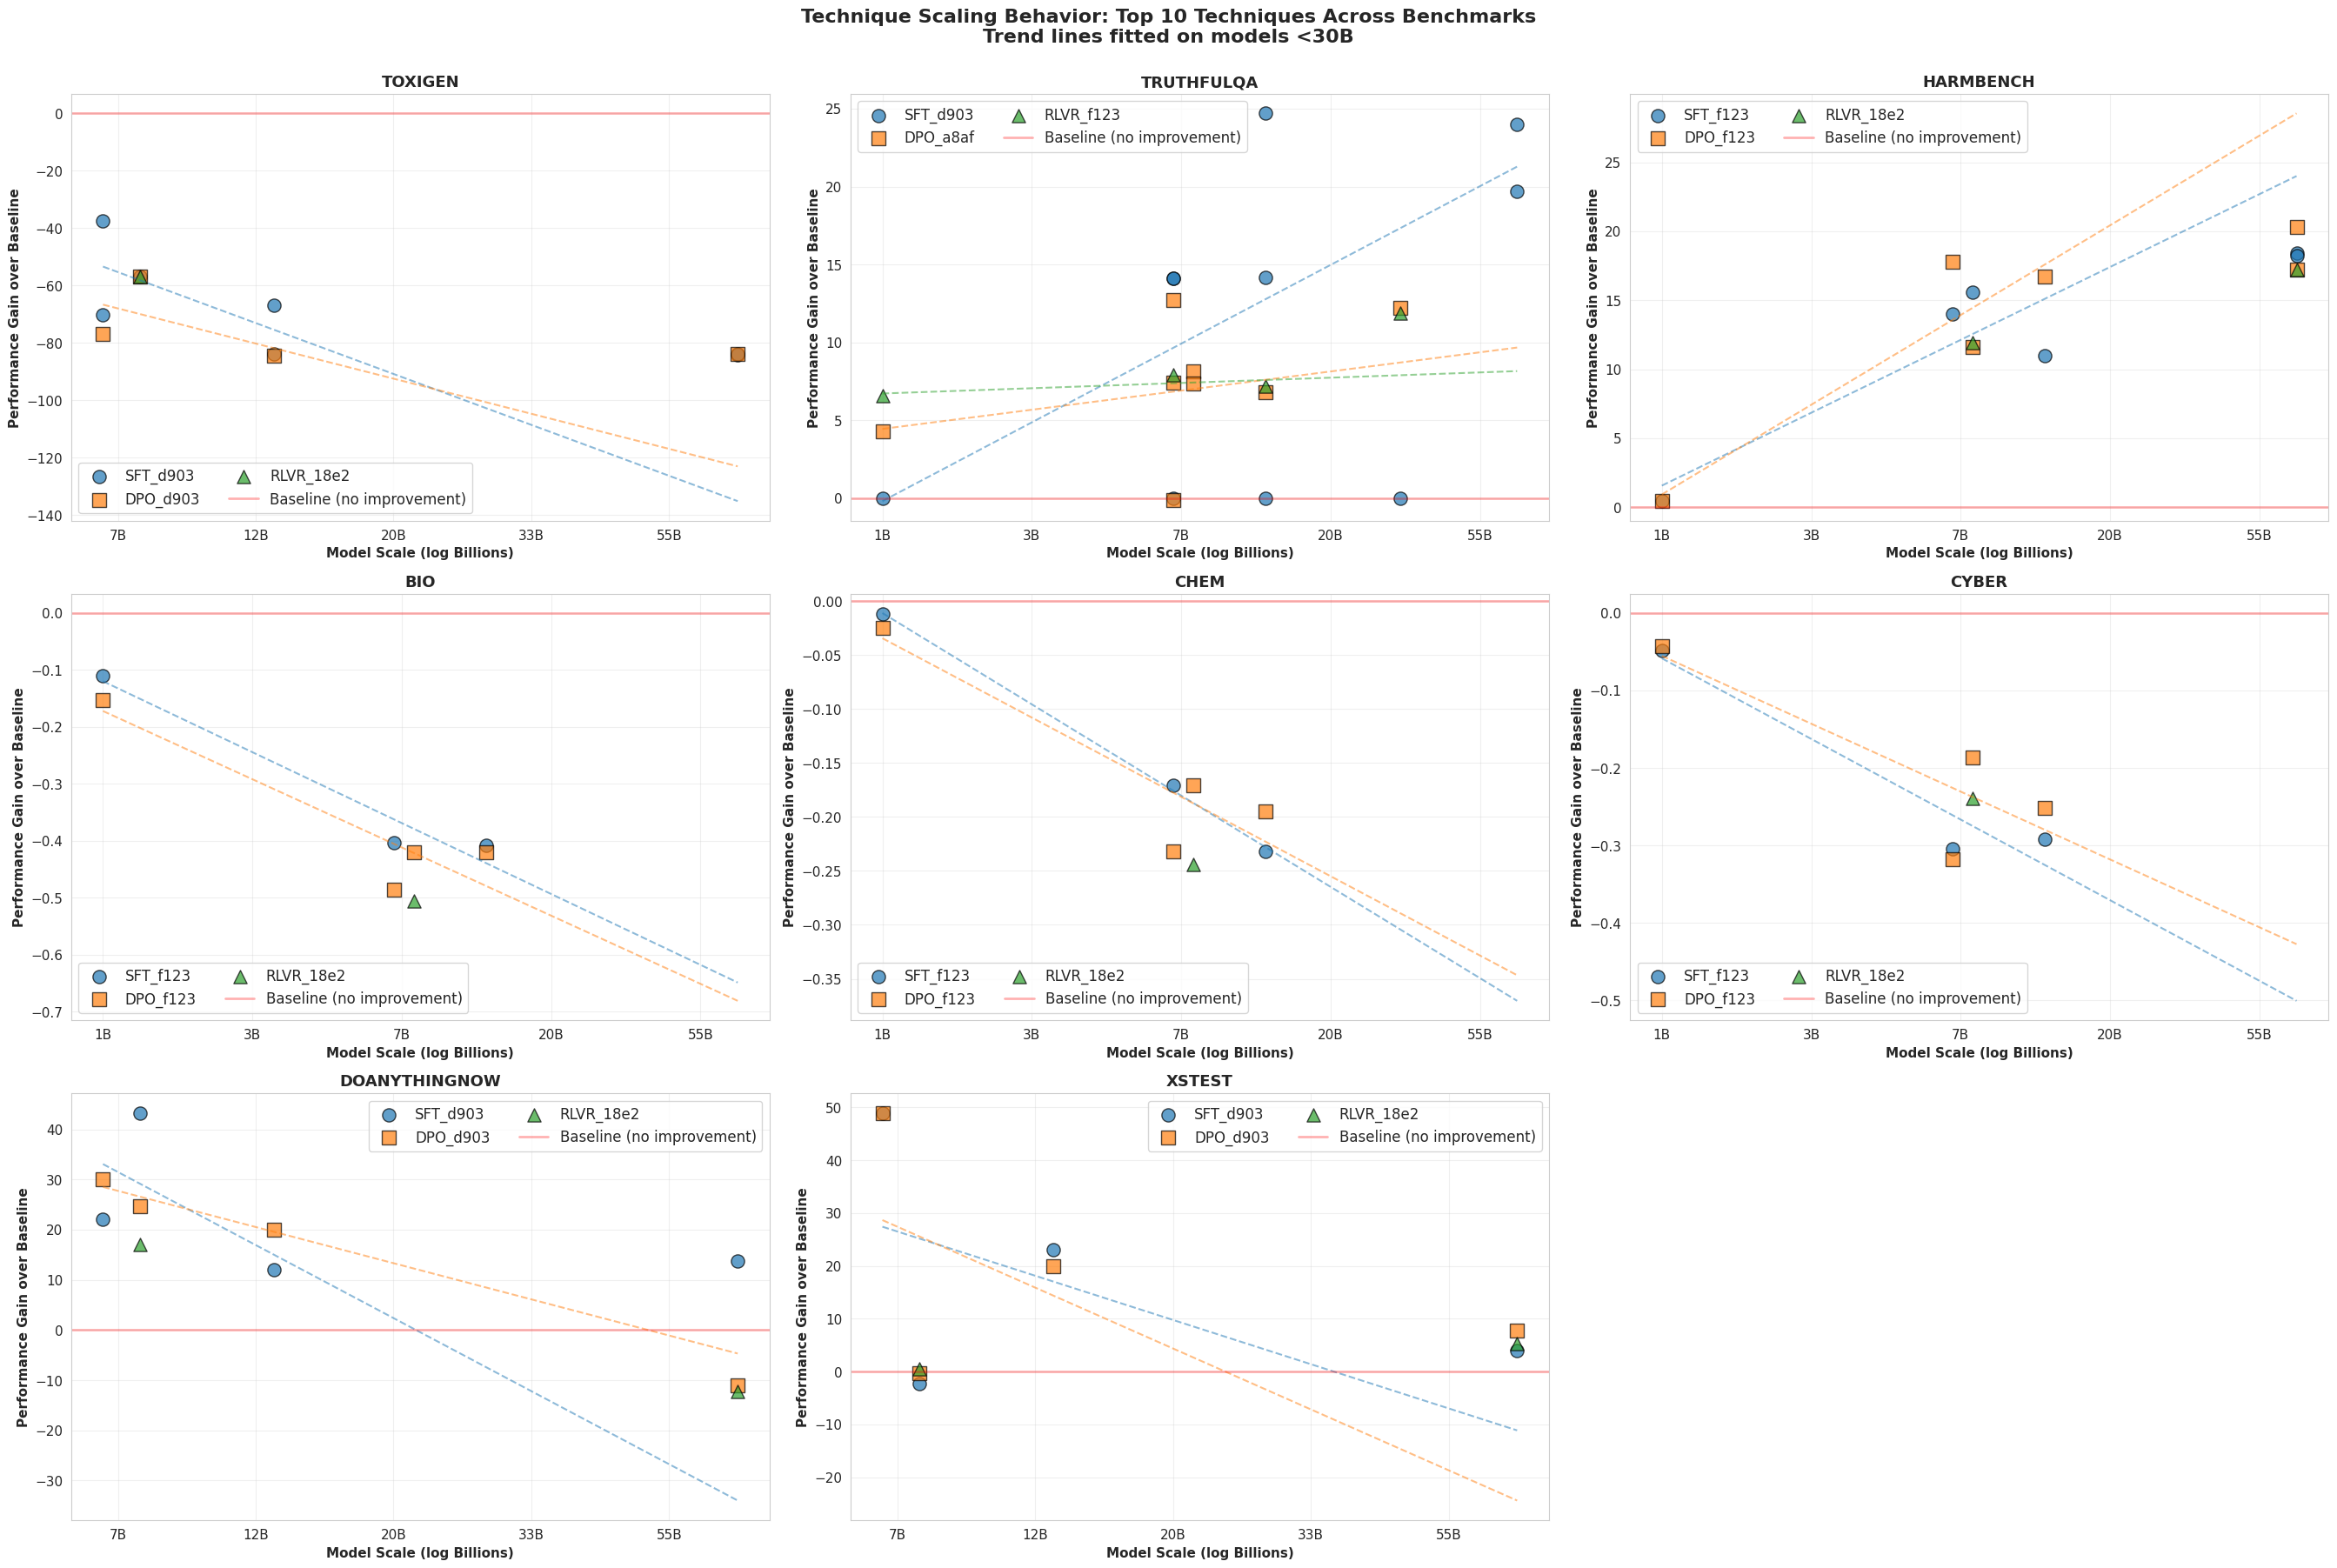


📊 How to read these plots:
  - Points above red line = technique better than baseline
  - Upward trend = technique effectiveness increases with scale
  - Downward trend = technique effectiveness decreases with scale
  - Flat trend = technique effectiveness stable across scales


In [244]:
# Scatter plots showing gain vs scale for each benchmark
# Show top 10 techniques by data point count
top_technique_ids = diff_df['technique_id'].value_counts().head(10).index
diff_plot = diff_df[diff_df['technique_id'].isin(top_technique_ids)]

benchmarks = diff_plot['Benchmark'].unique()
n_benchmarks = len(benchmarks)
n_cols = min(3, n_benchmarks)
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9*n_cols, 6*n_rows))
if n_benchmarks == 1:
  axes = [axes]
else:
  axes = axes.flatten() if n_benchmarks > 1 else [axes]

# Color map for techniques
colors_map = {tid: plt.cm.tab10(i % 10) for i, tid in enumerate(top_technique_ids)}
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']

for idx, benchmark in enumerate(benchmarks):
  if idx >= len(axes):
    break
  
  ax = axes[idx]
  
  # Plot each technique
  for tech_idx, technique_id in enumerate(top_technique_ids):
    subset = diff_plot[
      (diff_plot['technique_id'] == technique_id) &
      (diff_plot['Benchmark'] == benchmark)
    ]
    
    if len(subset) > 0:
      tech_name = subset['Technique'].iloc[0]
      
      # Use log scale for x-axis
      ax.scatter(np.log(subset['scale_numeric']), subset['Diff_from_baseline'],
            s=120, alpha=0.7, color=colors_map[technique_id],
            marker=markers[tech_idx % len(markers)],
            label=f"{tech_name[:15]}_{subset['paper_id'].iloc[0][:4]}",
            edgecolors='black', linewidth=1)
      
      # Add trend line if multiple points, only for models with scale < 30B
      subset_small = subset[subset['scale_numeric'] < 30]
      if len(subset_small) >= 2:
        scales = np.log(subset_small['scale_numeric'].values.reshape(-1, 1))
        diffs = subset_small['Diff_from_baseline'].values
        model = LinearRegression()
        model.fit(scales, diffs)
        
        scale_range = np.linspace(np.log(subset_small['scale_numeric'].min()), 
                    np.log(70), 50)  # Extend line to full range
        pred = model.predict(scale_range.reshape(-1, 1))
        ax.plot(scale_range, pred, '--', color=colors_map[technique_id],
             linewidth=1.5, alpha=0.5)
  
  # Zero reference line
  ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.3,
        label='Baseline (no improvement)')
  
  ax.set_xlabel('Model Scale (log Billions)', fontsize=11, fontweight='bold')
  ax.set_ylabel('Performance Gain over Baseline', fontsize=11, fontweight='bold')
  ax.set_title(f'{benchmark}', fontsize=13, fontweight='bold')
  ax.legend(loc='best', fontsize=12, ncol=2)
  ax.grid(True, alpha=0.3)
  
  # Set x-axis tick labels to original scale values
  xticks = ax.get_xticks()
  ax.set_xticklabels([f'{np.exp(x):.0f}B' for x in xticks])

# Remove extra subplots
for idx in range(n_benchmarks, len(axes)):
  fig.delaxes(axes[idx])

plt.suptitle(f'Technique Scaling Behavior: Top 10 Techniques Across Benchmarks\nTrend lines fitted on models <30B',
      fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print('\n📊 How to read these plots:')
print('  - Points above red line = technique better than baseline')
print('  - Upward trend = technique effectiveness increases with scale')
print('  - Downward trend = technique effectiveness decreases with scale')
print('  - Flat trend = technique effectiveness stable across scales')

## 4.2 Technique Categorization: Which Techniques Are Best?

**This plot answers**: Which techniques give high performance gains AND scale well?

**How to read**:
- **X-axis (Slope)**: How gain changes with scale (positive = better at larger models)
- **Y-axis (Mean Gain)**: Average performance improvement over baseline
- **Size**: Number of data points (bigger = more evidence)

**What you want**: Top-right quadrant (high gain + scales well)

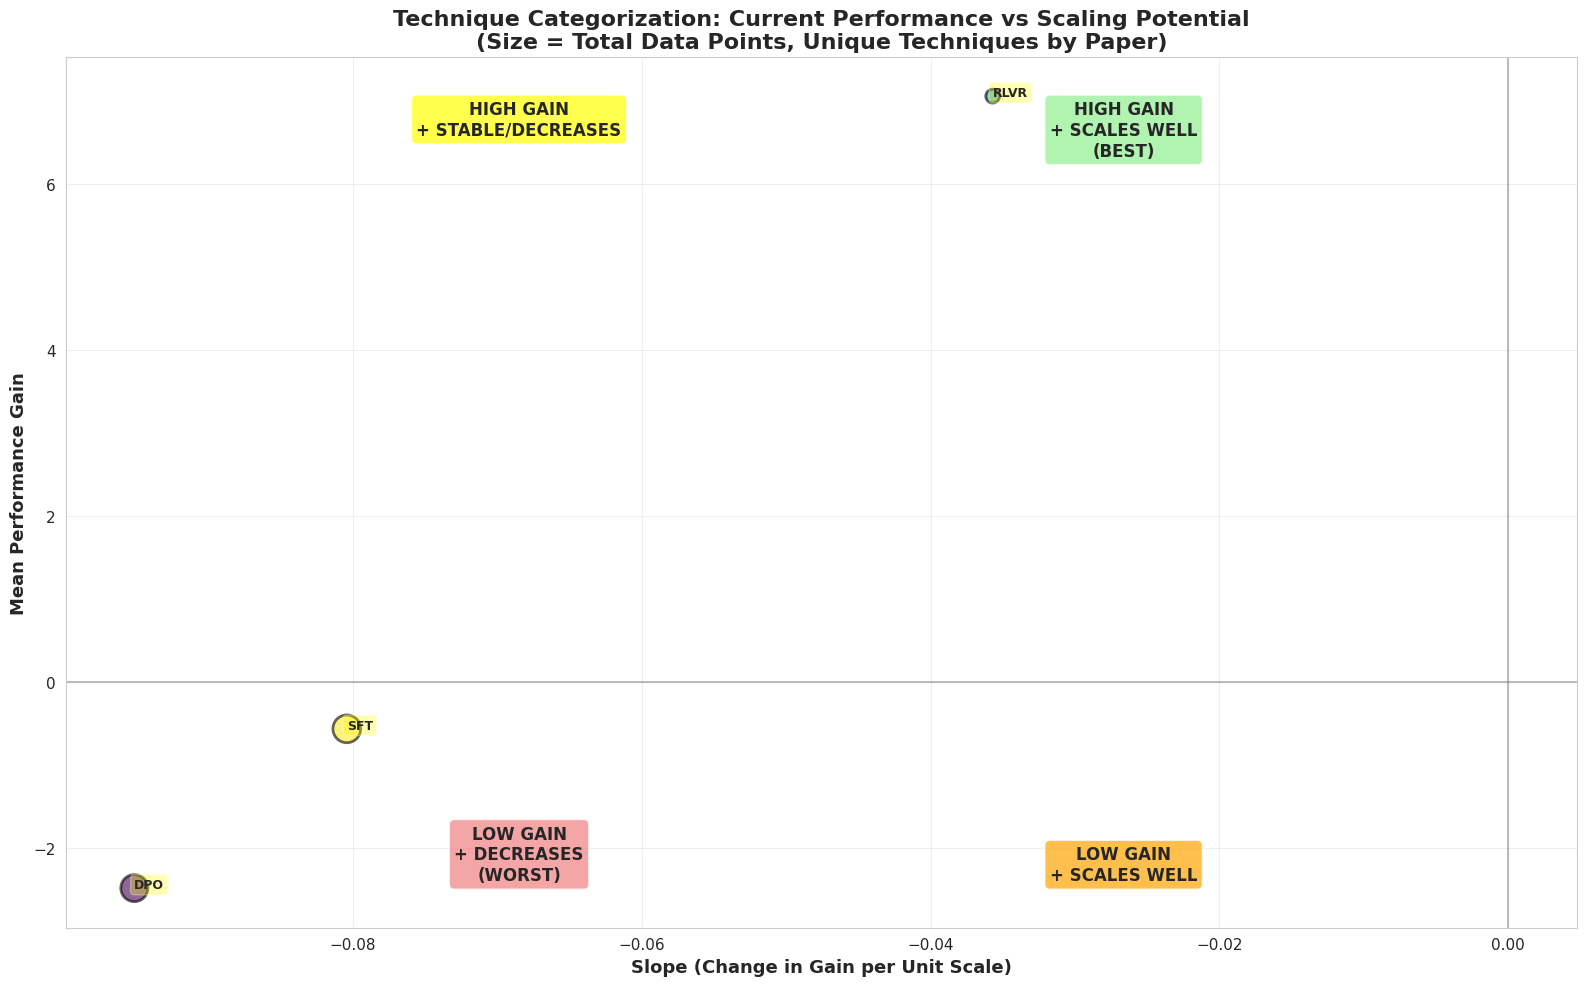


📊 Total unique techniques analyzed: 3


In [242]:
# Scatter plot: Slope vs Mean Gain
# UPDATED: Group by technique_id for unique techniques
tech_summary = tech_scaling_df.groupby('technique_id').agg({
    'Technique': 'first',
    'Slope': 'mean',
    'Mean_gain': 'mean',
    'N_points': 'sum'
}).reset_index()

tech_summary_filtered = tech_summary[tech_summary['N_points'] >= 5]

fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(tech_summary_filtered['Slope'], 
                    tech_summary_filtered['Mean_gain'],
                    s=tech_summary_filtered['N_points'] * 10,
                    alpha=0.6, c=range(len(tech_summary_filtered)),
                    cmap='viridis', edgecolors='black', linewidth=2)

# Add labels
for _, row in tech_summary_filtered.iterrows():
    label = row['Technique'][:20] if len(row['Technique']) > 20 else row['Technique']
    ax.annotate(label, 
               (row['Slope'], row['Mean_gain']),
               fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Add quadrant lines
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5)

# Add quadrant labels
ax.text(0.7, 0.95, 'HIGH GAIN\n+ SCALES WELL\n(BEST)', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
       ha='center', va='top')
ax.text(0.3, 0.95, 'HIGH GAIN\n+ STABLE/DECREASES', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
       ha='center', va='top')
ax.text(0.7, 0.05, 'LOW GAIN\n+ SCALES WELL', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
       ha='center', va='bottom')
ax.text(0.3, 0.05, 'LOW GAIN\n+ DECREASES\n(WORST)', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
       ha='center', va='bottom')

ax.set_xlabel('Slope (Change in Gain per Unit Scale)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Performance Gain', fontsize=13, fontweight='bold')
ax.set_title('Technique Categorization: Current Performance vs Scaling Potential\n(Size = Total Data Points, Unique Techniques by Paper)',
            fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n📊 Total unique techniques analyzed: {len(tech_summary_filtered)}')